# Tracking of a Rotating Ring

In this code, we read in a set of .png images, track the location of marked particles using trackpy, extract the x- and y- location of each particle, and analyze the data.

In [32]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.rc('image', cmap='gray')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,20)
plt.rc('legend',**{'fontsize':18})
plt.rcParams.update({'font.size': 18})


#calculates the timestep for any image based on a known frame rate
def times (ImageNumber, FrameRate):
    t = []
    for i in range(len(ImageNumber)):
        t.append(i*(1/FrameRate))
    return t


#calculates angular velocity based on angle and time
def Omega(theta, time):
    omega = []
    for i in range(len(theta)-1):
        omega.append((theta[i+1]-theta[i])/(time[i+1]-time[i]))
    return omega


#determines the distance between any two points, given their x and y coordinates
def side_length(x1, y1, x2, y2):
    length = []
    for i in range(len(x1)):
        length.append(math.hypot((x2[i]-x1[i]), (y2[i]-y1[i])))
    return length


#calculates the midpoint between any points from their x and y coordinates
def midpoint(Ax, Ay, Bx, By):
    m = []
    for i in range(len(Ax)):
        m.append([0.5*(Ax[i]+Bx[i]), 0.5*(Ay[i]+By[i])])
    return m


#takes any two points and returns the vector components between
def Vectorize(x1, y1, x2, y2):
    vector = []
    for i in range(len(x1)):
        vector.append([(x2[i]-x1[i]), (y2[i]-y1[i])])
    return vector


#finds the center of the three dots based on the distances between them
def CenterDotFinder(dots):
    Ax, Ay, Bx, By, Cx, Cy = dots
    Len1 = side_length(Ax, Ay, Bx, By)
    Len2 = side_length(Bx, By, Cx, Cy)
    Len3 = side_length(Ax, Ay, Cx, Cy)


    CenterX = []
    CenterY = []
    A_x = []
    A_y = []
    B_x = []
    B_y = []

    if Len1>Len2 and Len1>Len3:
        CenterX = np.array(Cx)
        CenterY = np.array(Cy)
        A_x = np.array(Ax)
        A_y = np.array(Ay)
        B_x = np.array(Bx)
        B_y = np.array(By)
    
    elif Len2>Len1 and Len2>Len3:
        CenterX = np.array(Ax)
        CenterY = np.array(Ay)
        A_x = np.array(Bx)
        A_y = np.array(By)
        B_x = np.array(Cx)
        B_y = np.array(Cy)
    
    elif Len3 > Len1 and Len3 > Len2:
        CenterX = np.array(Bx)
        CenterY = np.array(By)
        A_x = np.array(Ax)
        A_y = np.array(Ay)
        B_x = np.array(Cx)
        B_y = np.array(Cy)
    return CenterX, CenterY, A_x, A_y, B_x, B_y


#calculates the angle of a triangle using the law of cosines
def angle(opp, sideA, sideB):
    phi = []
    for i in range(len(opp)):
        phi.append(np.arccos((sideA[i]**2+sideB[i]**2-opp[i]**2)/(2*sideA[i]*sideB[i])))
    return phi  


#pulls the x and y positions of 3 dots from a tracked dataframe
def rawPosition(dataFrame):
    Ax = []
    Ay = []
    Bx = []
    By = []
    Cx = []
    Cy = []

    for i in range(len(dataFrame.x)):
        if dataFrame.particle[i] == 0.0:
            Ax.append(dataFrame.x[i])
            Ay.append(dataFrame.y[i])
        elif dataFrame.particle[i] == 1.0:
            Bx.append(dataFrame.x[i])
            By.append(dataFrame.y[i])
        elif dataFrame.particle[i] == 2.0:
            Cx.append(dataFrame.x[i])
            Cy.append(dataFrame.y[i])
    return Ax, Ay, Bx, By, Cx, Cy


#calculates the distance in pixels by which the center dot 'wobbles' across the center line
def wobbleDistance(side, angle, VectorA, VectorB):
    sign = []
    distance = []
    for i in range(len(side)):
        sign.append(np.sign(np.cross(VectorA[i], VectorB[i])))
        distance.append(sign[i]*(side[i]*np.sin(angle[i])))
    return distance

#determines angle of the ring's wobble based on a given wobble distance and ring diameter (units must match)
def wobbleAngle(distance, ringDiameter):
    angle = [] 
    for i in range(len(distance)):
        angle.append(np.arcsin(distance[i]/ringDiameter))
    return angle

## Variable Parameters

After importing all of the packages needed for this code and defining any needed functions, we need to specify the path to the individual images to be analyzed, as well as the paths for saving out the batched and linked particles.  We also must define some parameters for trackpy.  These parameters are used throughout the code.

In [33]:
fileNameIn = '5MinVid/image*.png' #folder and names of the png files to be analyzed
batchedFileName = '5MinVidBatched.csv'
trackingFileName = '5MinVidTracked.csv'

sphereSize = 25 #expected size in pixels: err on high side
sphereMass = 1000 #minimum colormass 
pixelsMoved = 40 #expected max number of pixels to move per frame
frameNumber = 2 #individual frame number for testing
trackingStartFrame = 0 #frame number to start tracking
trackingEndFrame = -1 #frame number to end tracking
stubLength = 1 #number of frames a particle must be present for
memorytime = 250

videoFrameRate = 40 #in fps

Here, we read in the individual images (in greyscale) from png files. The path is defined earlier as 'fileNameIn.' We also see some basic information about the image sequence.  As a test, we can see what particles trackpy finds in a given frame.  We can use information in this cell to narrow our parameters above.

In [34]:
frames = pims.ImageSequence(fileNameIn, as_grey=True)
print(frames)

f = tp.locate(frames[frameNumber], sphereSize, minmass = sphereMass)
f.head()

<Frames>
Source: /home/katherine/Documents/Git/ElectromagneticRing/5MinVid/image*.png
Length: 11998 frames
Frame Shape: (728, 1024, 3)
Pixel Datatype: uint8


,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,519.757412,141.318118,11145.932644,7.471054,0.103801,39.164813,14440.0,0.004207,2
1,516.374342,333.493625,33671.667814,7.922908,0.015971,95.114545,43649.0,0.001381,2
2,534.080821,581.172106,12262.316300,7.426777,0.093232,46.624777,16022.0,0.003787,2


As another check before running the entire image sequence through trackpy, we show the image with the 'found' circles overlayed.  This helps identify any unintentional particles, and help with the filtering.

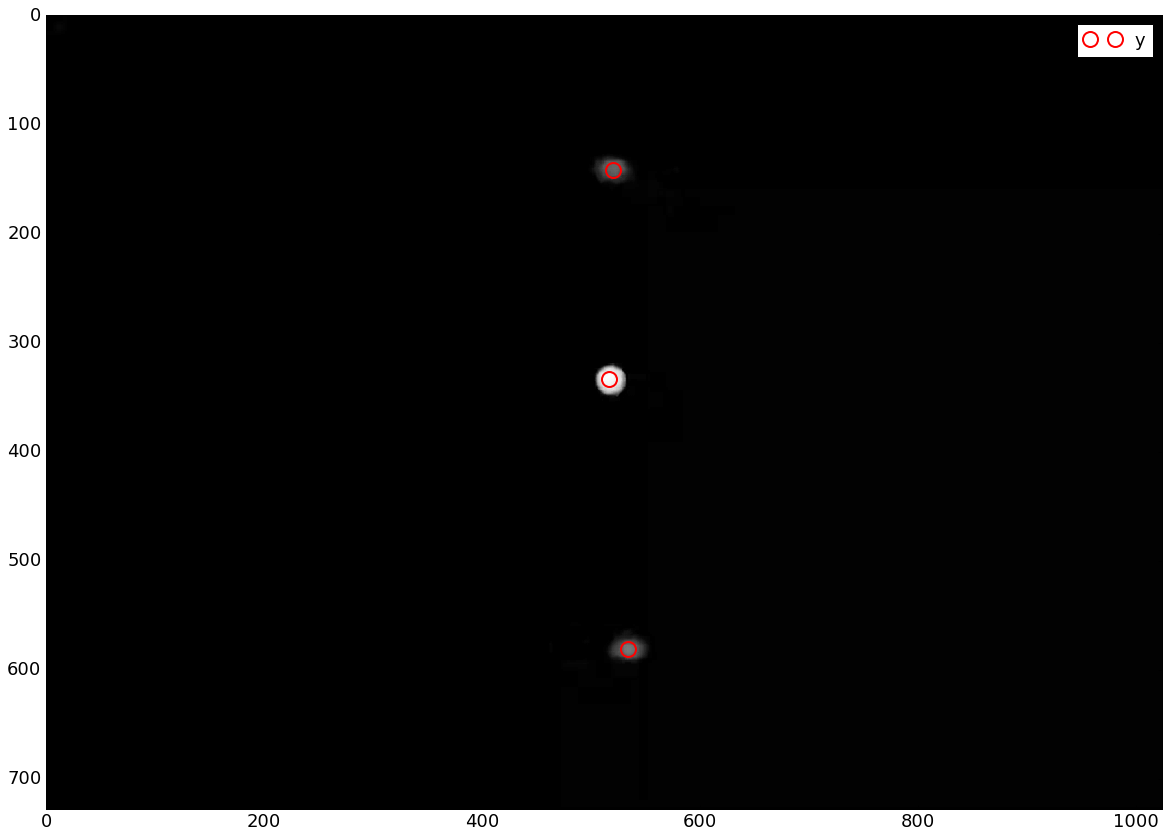

In [35]:
plt.figure()
tp.annotate(f, frames[frameNumber])

If we are satisfied with our parameters, we can proceed.  The next cell locates objects in a range of frames, with a given minimum size and colormass.  It also saves the dataframe to a csv file, which can be read in later to avoid having to batch an image sequence multiple times.
### Warning : This can take quite a long time, depending on the length of the image sequence, minmass, and sphere size!

```python
f = tp.batch(frames[trackingStartFrame:trackingEndFrame], sphereSize, minmass = sphereMass)
f.to_csv(batchedFileName)
```

```python
f = pd.read_csv(batchedFileName)
t = tp.link_df(f, pixelsMoved, memory=memorytime)

#links the trajectories for all particles.
#The user must provide a max number of pixels an object is expected to move.

t.to_csv(trackingFileName)
```

Here we plot the trajectories of all particles.

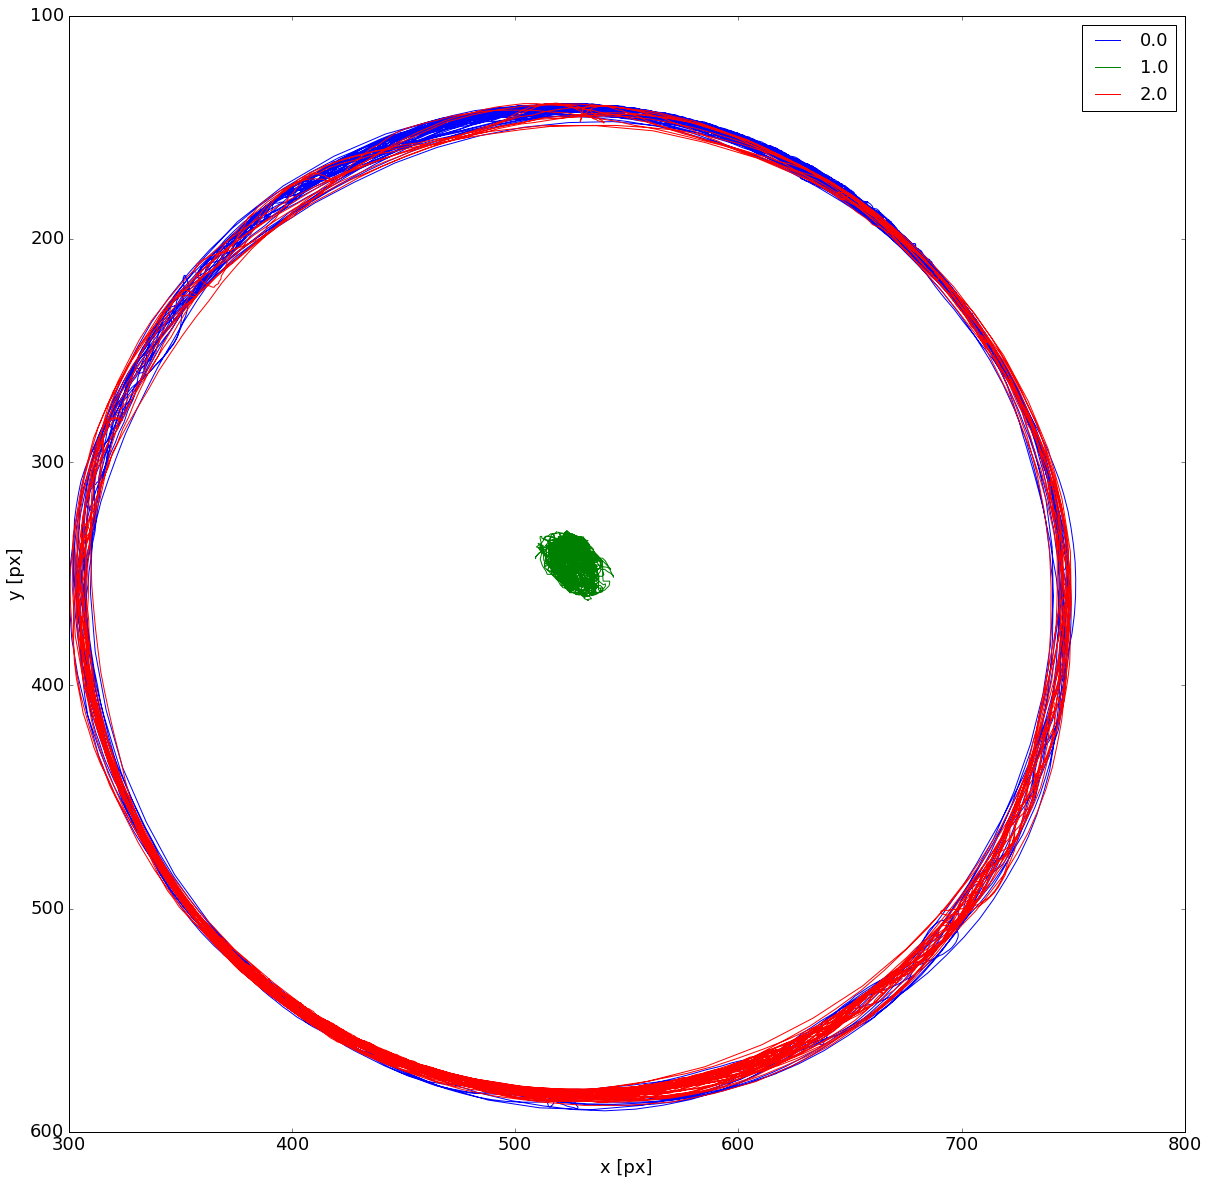

In [36]:
t = pd.read_csv(trackingFileName)
plt.figure()
tp.plot_traj(t)
plt.show()
#shows the trajectories of the particles

As necessary, we can filter the trajectories and eliminate any short 'stubs' until we have the desired number of trajectories.

```python
t1 = tp.filter_stubs(t, stubLength)
# Compare the number of particles in the unfiltered and filtered data.
print('Before Filtering:', t['particle'].nunique())
print('After Filtering:', t1['particle'].nunique())
```

## Data Analysis

The first bit of data analysis pulls the position and particle data from the dataframe and identifies which of the three particles is the center.  Once the center is defined, we calculate the midpoint between the outer two dots.  The last part of this basic analysis gives us a list of times for each position.

In [37]:
#selects position data from dataframe
positions = rawPosition(t)
RawAx, RawAy, RawBx, RawBy, RawCx, RawCy = positions 

#identifies center dot, assigns other two to A and B
CenterDot = CenterDotFinder(positions)
CenterX, CenterY, A_x, A_y, B_x, B_y = CenterDot

#calculates the midpoint between point A and point B
midpointCoordinates = np.array(midpoint(A_x, A_y, B_x, B_y))
midpoint_x = midpointCoordinates[: ,0]
midpoint_y = midpointCoordinates[: ,1]

#calculates the distance between all dots in pixels, where C is the center dot.
AB = side_length(A_x, A_y, B_x, B_y)
AC = side_length(A_x, A_y, CenterX, CenterY)
BC = side_length(B_x, B_y, CenterX, CenterY)

#calculates the angle between vector AC and AB: result in radians
AngleCAB = angle(BC, AC, AB)

#creates a list of times the length of A_x
time = times(A_x, videoFrameRate)

Now that we have the position extracted, we can plot the angular position of the dots.  First, we  calculate the angle using the arctan function, where $\theta = tan^{-1}( \frac{y}{x})$.  As this gives us a result bounded by $- \pi$ and $\pi$, we must 'unwrap' the function, allowing the display of multiple revolutions.  

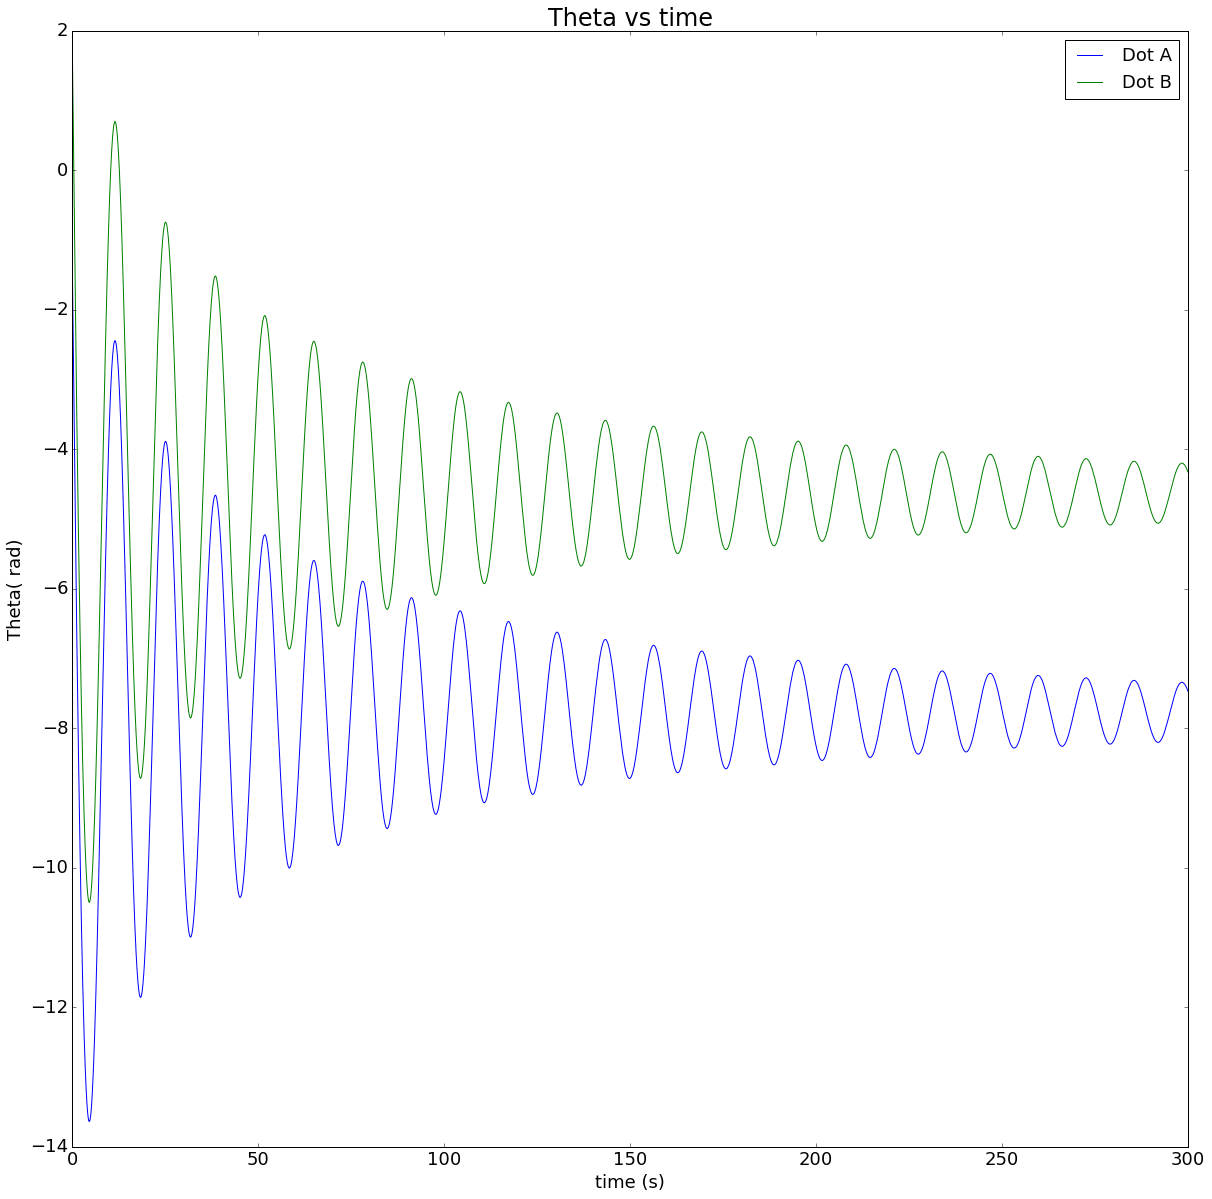

In [38]:
thetaACentered = []
thetaBCentered = []

for i in range(len(A_y)):
    thetaACentered.append(np.arctan2((A_y[i]-midpoint_y[i]), (A_x[i]-midpoint_x[i])))
    thetaBCentered.append(np.arctan2((B_y[i]-midpoint_y[i]), (B_x[i]-midpoint_x[i])))
    
#the above gives us a result bounded by -pi and pi.  Below, we must 'unwrap' the angle.

theta_A = []
theta_B = []
j=0
for i in range(len(thetaACentered)):
    if thetaACentered[i]-thetaACentered[i-1]>np.pi:
        j-=(2*np.pi)
    elif thetaACentered[i]-thetaACentered[i-1]<-(np.pi):
        j+=(2*np.pi)
    theta_A.append(thetaACentered[i]+j)
k=0
for i in range(len(thetaBCentered)):
    if thetaBCentered[i]-thetaBCentered[i-1]>np.pi:
        k-=(2*np.pi)
    elif thetaBCentered[i]-thetaBCentered[i-1]<-np.pi:
        k+=(2*np.pi)
    theta_B.append(thetaBCentered[i]+k)
    
    
plt.plot(time, theta_A, label='Dot A')
plt.plot(time, theta_B, label='Dot B')
plt.xlabel('time (s)', fontsize = 18)
plt.ylabel('Theta( rad)', fontsize = 18)
plt.title('Theta vs time', fontsize = 24)
plt.legend(loc = "upper right")
plt.show()

From angular position, we can then find the angular velocity.

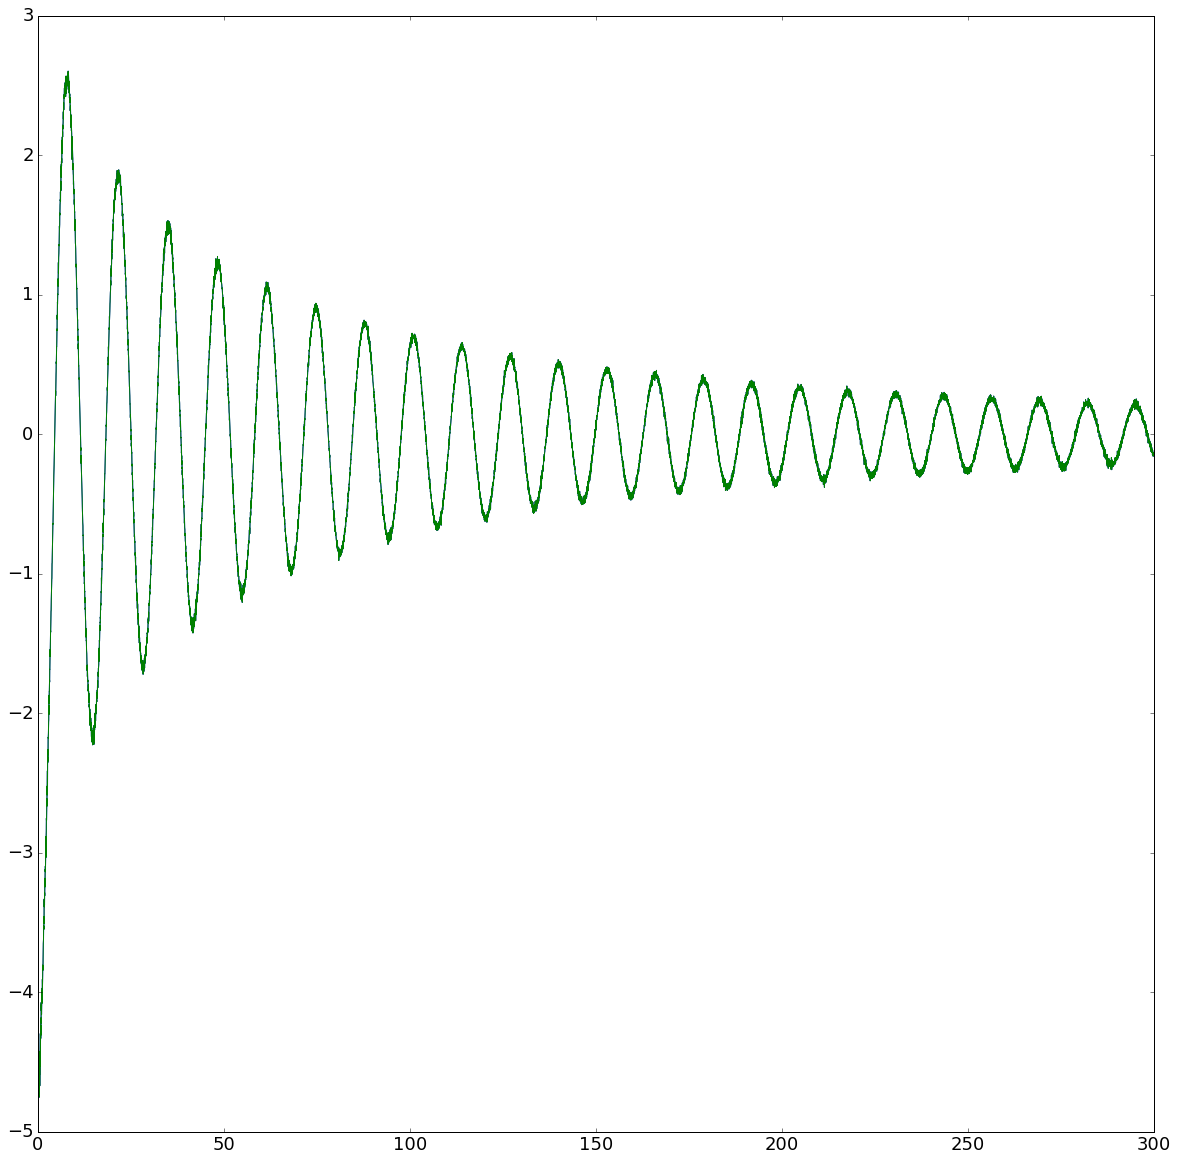

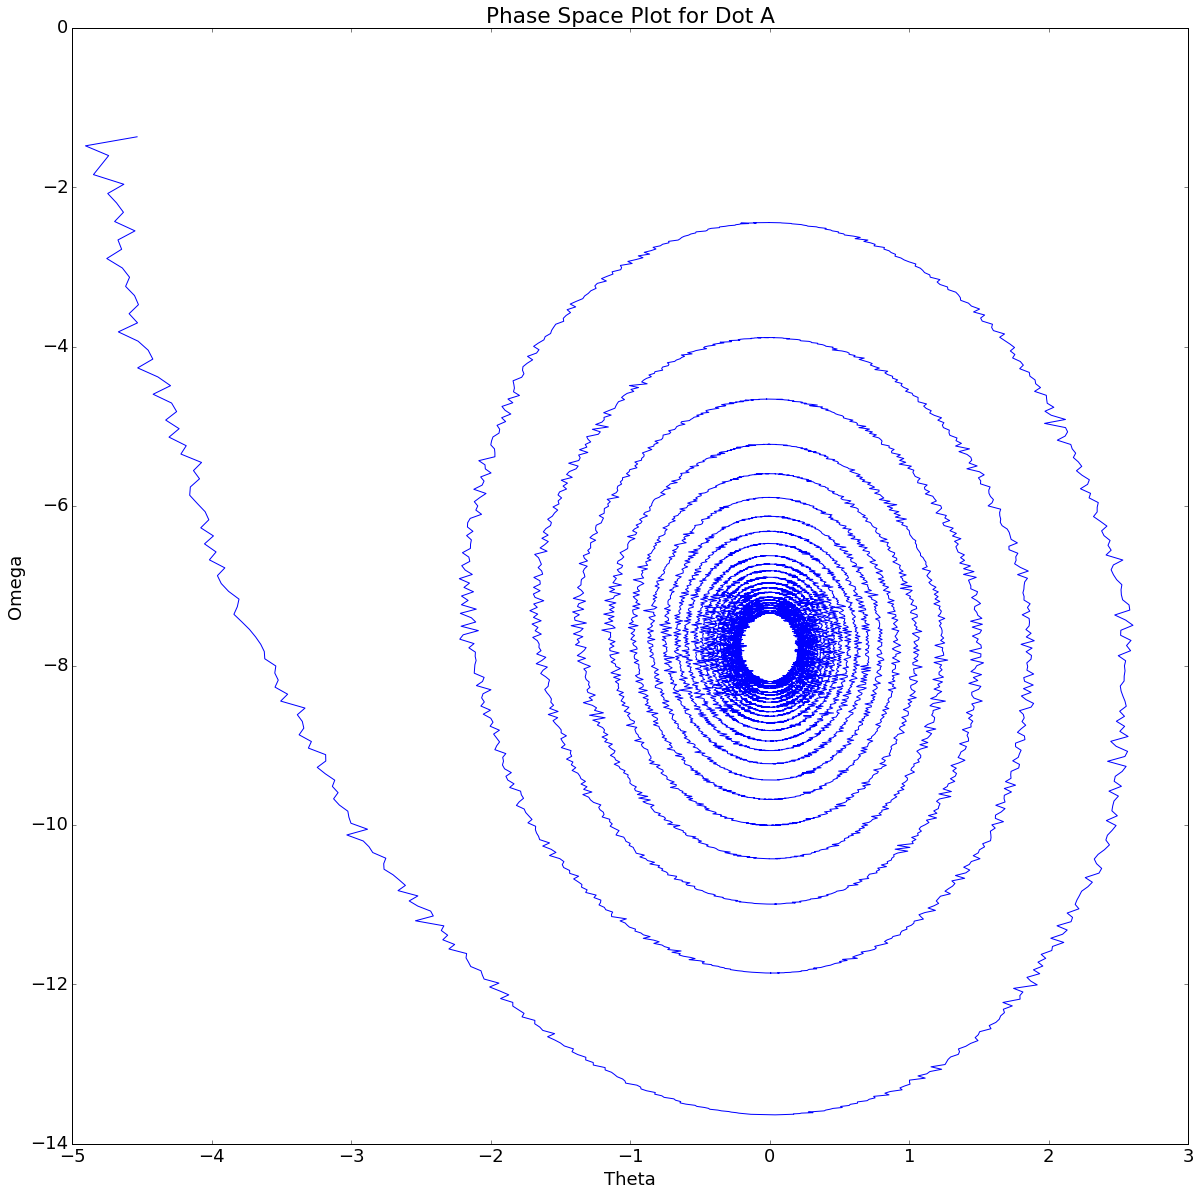

In [39]:
omega_A = Omega(theta_A, time)
omega_B = Omega(theta_B, time)


plt.plot(time[0:-1], omega_A)
plt.plot(time[0:-1], omega_B)
plt.show()

plt.plot(omega_A, theta_A[0:-1])
plt.xlabel('Theta')
plt.ylabel('Omega')
plt.title('Phase Space Plot for Dot A')
plt.show()

## More Analysis

Now that we have the pendulum oscillation subtracted from the ring's movement, we can begin to find the subtle 'wobble' and 'rocking' oscillations (where rocking is the ring oscillating as if it were balanced on one edge and rocked, and wobbling is the oscillation perpendicular to that in the x-y plane).

To calculate wobble, we find the distance the center dot moves from the line AB, determine which side of the line it is on using the sign of the cross product, and calculate the angle through which it rotates (as measured from the torsion fiber attachment point).

In [40]:
ABVector = Vectorize(A_x, A_y, B_x, B_y)
ACVector = Vectorize(A_x, A_y, CenterX, CenterY)
WobbleDist = wobbleDistance(AC, AngleCAB, ABVector, ACVector)
wobbleTheta = wobbleAngle(WobbleDist, max(AB))

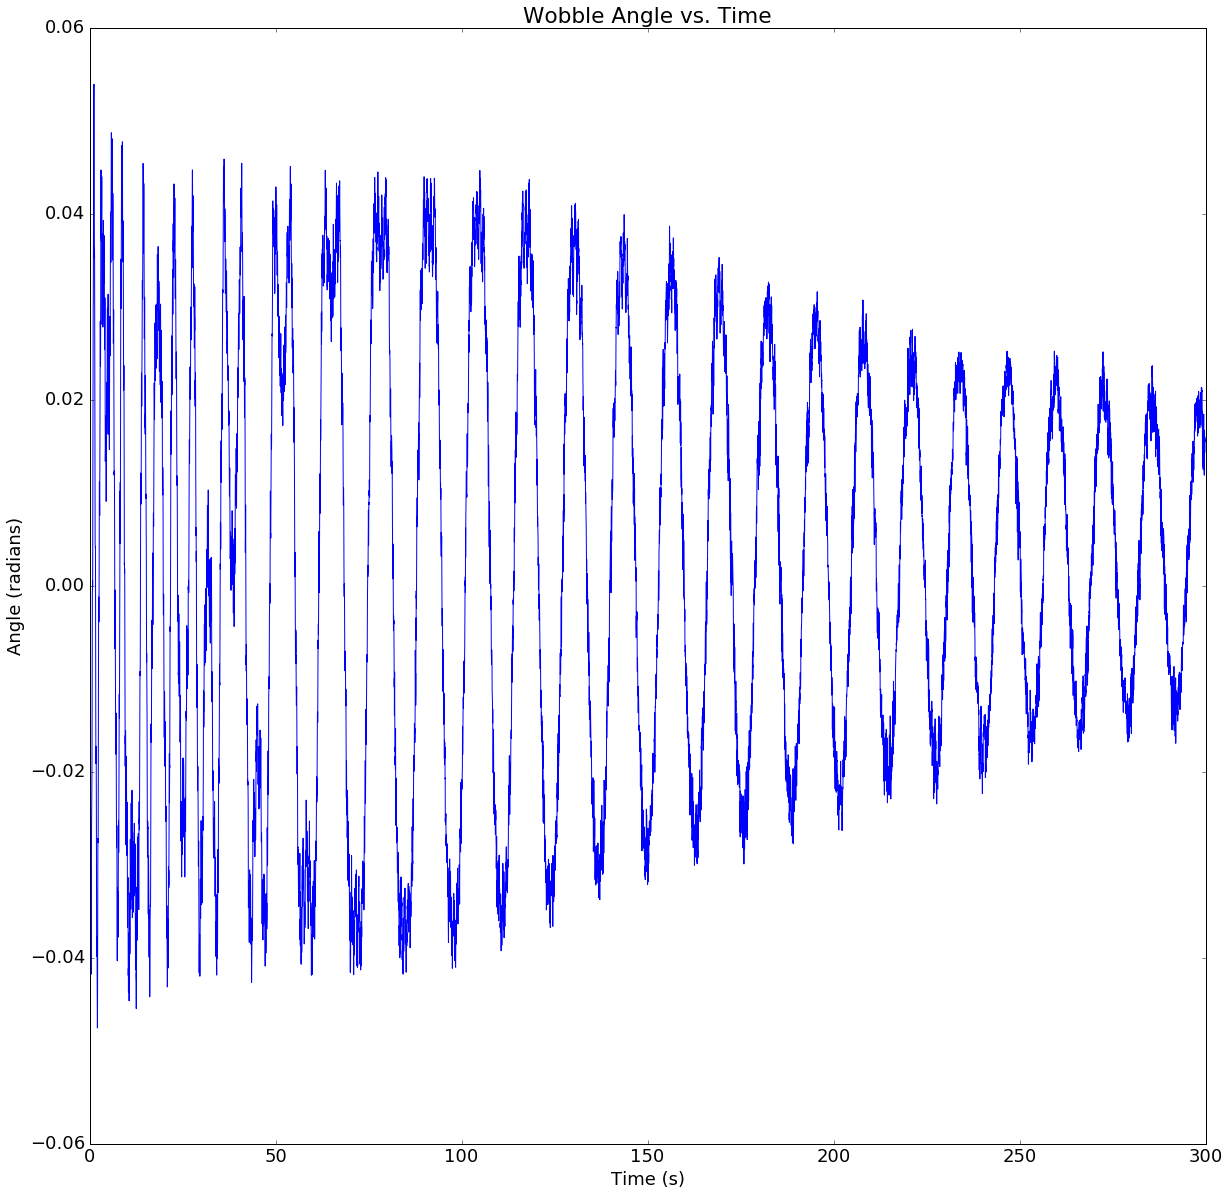

In [41]:
plt.plot(time, wobbleTheta)
plt.title('Wobble Angle vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.show()
#plt.plot(time, rockingDistance)

```python
def noWobble(ax, ay, centerx, centery, wx, wy):
    noW =  []
    for i in range(len(ax)):
        noW.append([(ax-(np.abs(centerx-wx))), (ay-(np.abs(centery-wy)))])
    return noW

```

The next cell represents the phase space plot over time, in a 3-d graph.  It just looks super neat!

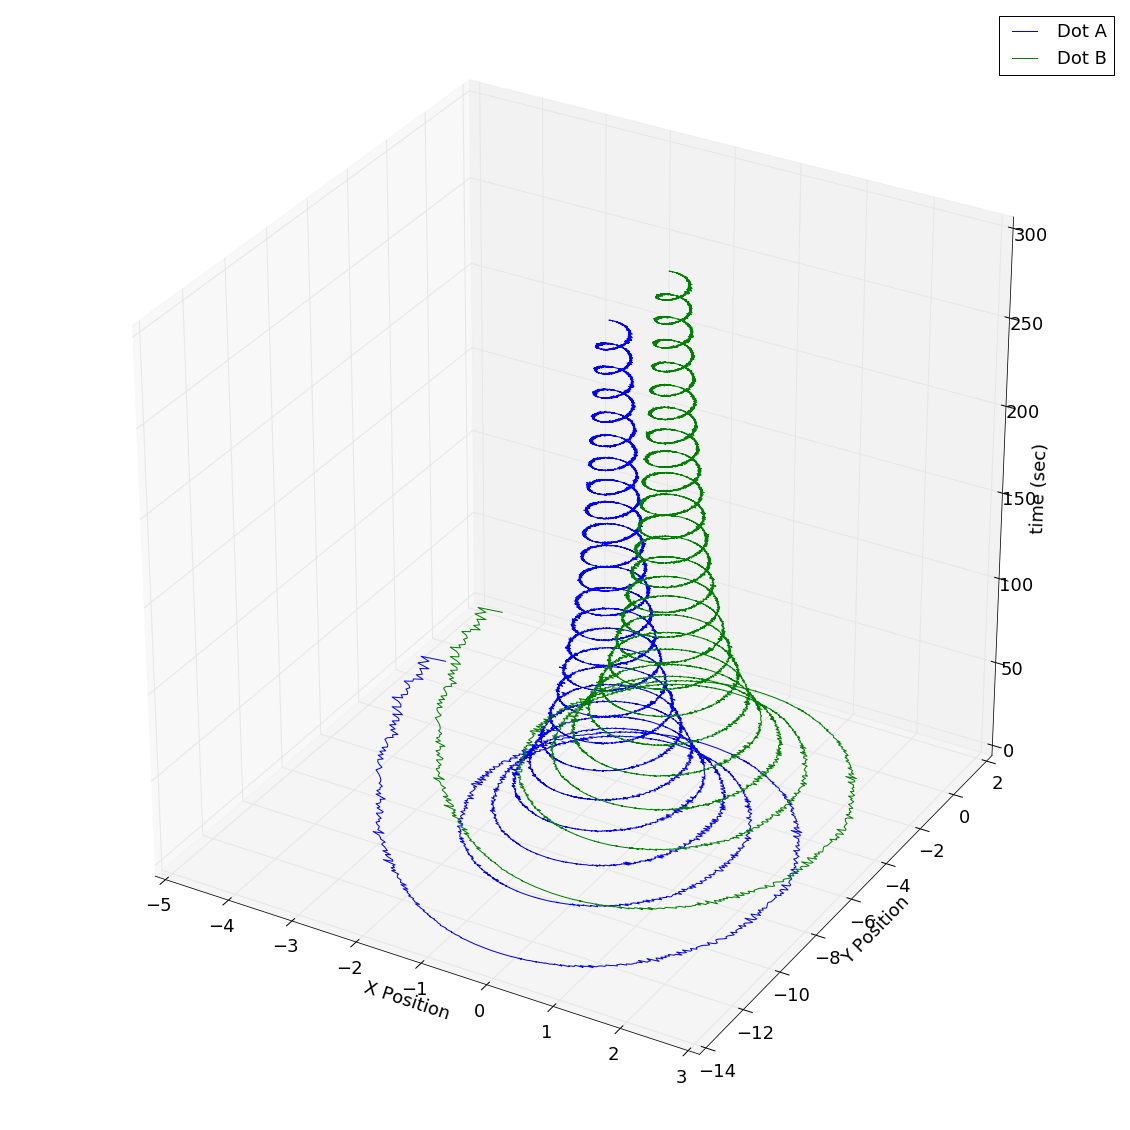

In [43]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(omega_A, theta_A[0:-1], time[0:-1], label='Dot A')
ax.plot(omega_B, theta_B[0:-1], time[0:-1], label= 'Dot B')
#ax.plot(CenterX, CenterY, time, label = 'Center Dot')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('time (sec)')

ax.legend()

plt.show()


In [29]:
MeanPositionUncertainty = t['ep'].mean()
MaxPositionUncertainty = t['ep'].max()
MedianPositionUncertainty = t['ep'].median()

print ("Average Uncertainty in Position: %f pixels" %(MeanPositionUncertainty))
print ("Maximum Uncertainty in Position: %f pixels" %(MaxPositionUncertainty))
print ("Median Uncertainty in Position: %f pixels" %(MedianPositionUncertainty))


HorizontalDistance = []
for i in range(len(A_x)):
    HorizontalDistance.append(math.hypot((B_x[i]-A_x[i]),(B_y[i]-A_y[i])))
print("Maximum Wobble is %f pixels" %(max(HorizontalDistance)))

Average Uncertainty in Position: 0.000026 pixels
Maximum Uncertainty in Position: 0.006269 pixels
Median Uncertainty in Position: 0.000023 pixels
Maximum Wobble is 444.519073 pixels


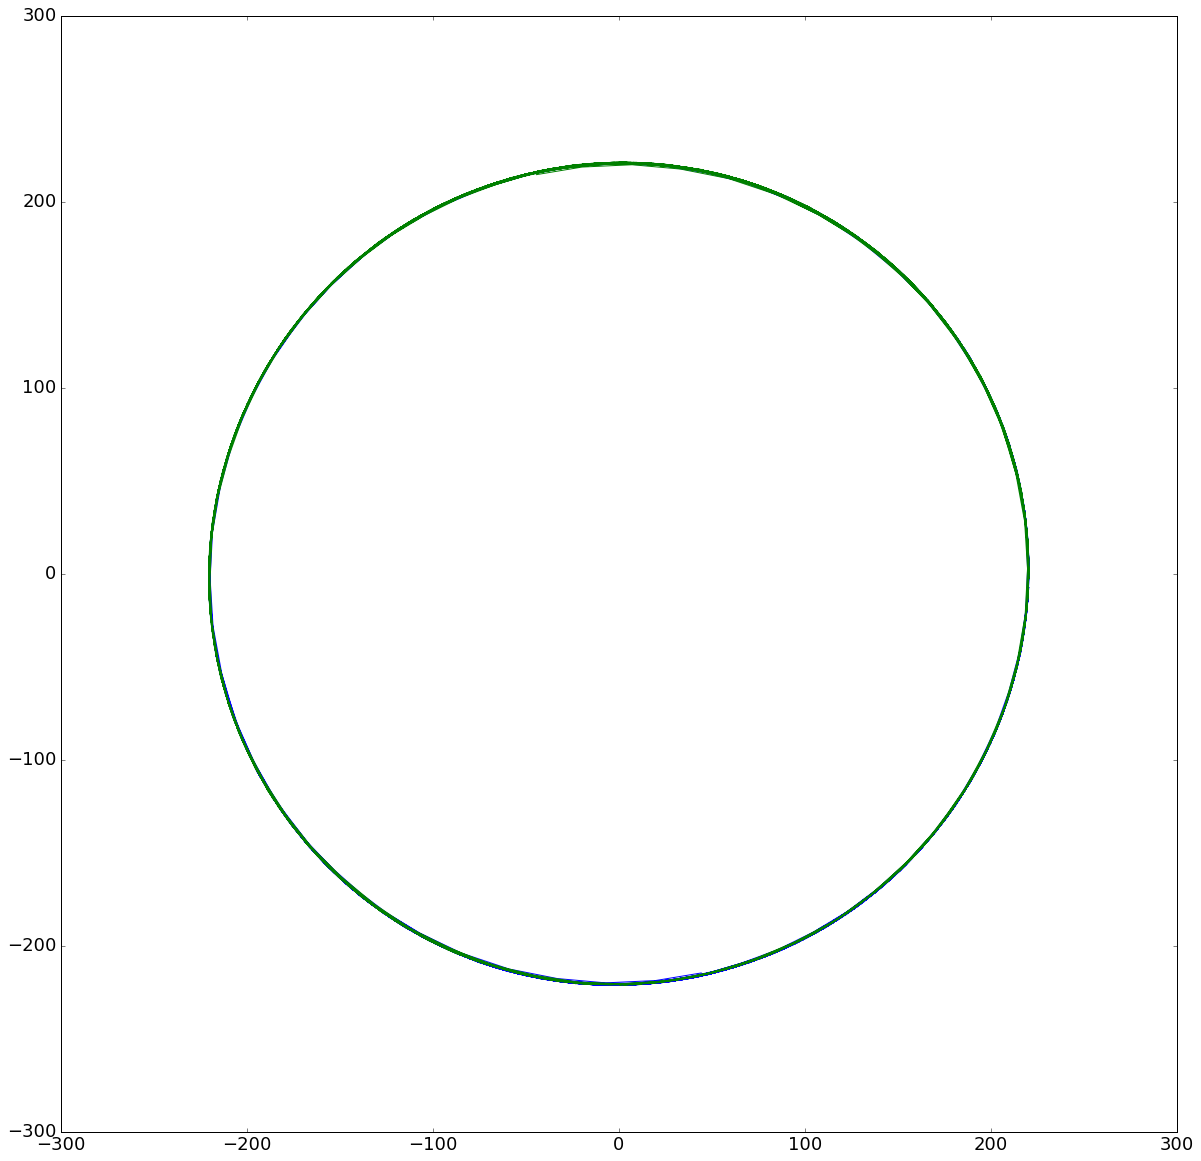

In [42]:
plt.plot(A_x-midpoint_x, A_y-midpoint_y)
plt.plot(B_x-midpoint_x, B_y-midpoint_y)
plt.show()